In [1]:
import tensorcircuit as tc
import optax
import jax.numpy as jnp
import jax
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rc('font', size=14)

key = jax.random.PRNGKey(42)
tf.random.set_seed(42)

2022-08-02 19:01:37.490534: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# dataset = 'mnist'
dataset = 'fashion'
readout_mode = 'softmax'
# readout_mode = 'sample'
encoding_mode = 'vanilla'
# encoding_mode = 'mean'
# encoding_mode = 'half'

In [3]:
n = 8
n_node = 8

In [4]:
K = tc.set_backend('jax')

In [5]:
# numpy data
if dataset == 'mnist':
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
elif dataset == 'fashion':
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
ind = y_test == 9
x_test, y_test = x_test[~ind], y_test[~ind]
ind = y_test == 8
x_test, y_test = x_test[~ind], y_test[~ind]
ind = y_train == 9
x_train, y_train = x_train[~ind], y_train[~ind]
ind = y_train == 8
x_train, y_train = x_train[~ind], y_train[~ind]

x_train = x_train / 255.0
if encoding_mode == 'vanilla':
    mean = 0
elif encoding_mode == 'mean':
    mean = jnp.mean(x_train, axis=0)
elif encoding_mode == 'half':
    mean = 0.5
x_train = x_train - mean
x_train = tf.image.resize(x_train[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_train = x_train / jnp.sqrt(jnp.sum(x_train**2, axis=-1, keepdims=True))

x_test = x_test / 255.0
x_test = x_test - mean
x_test = tf.image.resize(x_test[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_test = x_test / jnp.sqrt(jnp.sum(x_test**2, axis=-1, keepdims=True))

y_train = jax.nn.one_hot(y_train, n_node)
y_test = jax.nn.one_hot(y_test, n_node)

2022-08-02 19:01:45.017694: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-02 19:01:47.568991: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-02 19:01:47.569044: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30169 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:13:00.0, compute capability: 7.0


In [6]:
def clf(params, c, k):
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[3 * j, i])
            c.rz(i, theta=params[3 * j + 1, i])
            c.rx(i, theta=params[3 * j + 2, i])
    return c

def readout(c):
    if readout_mode == 'softmax':
        logits = []
        for i in range(n_node):
            logits.append(jnp.real(c.expectation([tc.gates.z(), [i,]])))
        logits = jnp.stack(logits, axis=-1) * 10
        probs = jax.nn.softmax(logits)
    elif readout_mode == 'sample':
        wf = jnp.abs(c.wavefunction()[:n_node])**2
        probs = wf / jnp.sum(wf)
    return probs

In [7]:
def loss(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    return -jnp.mean(y * jnp.log(probs))
loss = K.jit(loss, static_argnums=[3])

In [8]:
def accuracy(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    return jnp.argmax(probs, axis=-1) == jnp.argmax(y, axis=-1)
accuracy = K.jit(accuracy, static_argnums=[3])

In [9]:
k = 48

In [10]:
compute_loss = K.jit(K.vectorized_value_and_grad(loss, vectorized_argnums=[1, 2]), static_argnums=[3])
compute_accuracy = K.jit(K.vmap(accuracy, vectorized_argnums=[1, 2]), static_argnums=[3])

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 0, 0/375: loss=0.2204, acc=0.3828
epoch 0, 50/375: loss=0.0958, acc=0.7285
epoch 0, 100/375: loss=0.0950, acc=0.7383
epoch 0, 150/375: loss=0.0899, acc=0.7305
epoch 0, 200/375: loss=0.0900, acc=0.7383
epoch 0, 250/375: loss=0.0840, acc=0.7568
epoch 0, 300/375: loss=0.0833, acc=0.7617
epoch 0, 350/375: loss=0.0808, acc=0.7793
epoch 1, 0/375: loss=0.0818, acc=0.7646
epoch 1, 50/375: loss=0.0828, acc=0.7676
epoch 1, 100/375: loss=0.0873, acc=0.7383
epoch 1, 150/375: loss=0.0830, acc=0.7764
epoch 1, 200/375: loss=0.0874, acc=0.7471
epoch 1, 250/375: loss=0.0821, acc=0.7686
epoch 1, 300/375: loss=0.0807, acc=0.7725
epoch 1, 350/375: loss=0.0781, acc=0.7930
epoch 2, 0/375: loss=0.0798, acc=0.7773
epoch 2, 50/375: loss=0.0810, acc=0.7754
epoch 2, 100/375: loss=0.0844, acc=0.7627
epoch 2, 150/375: loss=0.0836, acc=0.7568
epoch 2, 200/375: loss=0.0851, acc=0.7520
epoch 2, 250/375: loss=0.0794, acc=0.7754
epoch 2, 300/375: loss=0.0793, acc=0.7715
epoch 2, 350/375: loss=0.0784, acc=0.7842


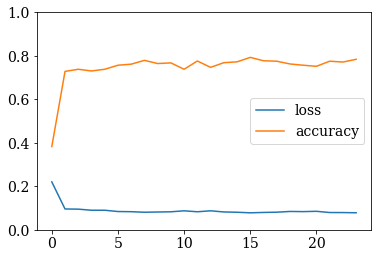

In [11]:
data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)

key, subkey = jax.random.split(key)
params = jax.random.normal(subkey, (3 * k, n))
opt = optax.adam(learning_rate=1e-2)
opt_state = opt.init(params)

loss_list = []
loss_list_train = []
acc_list = []
acc_list_train = []
for e in tqdm(range(3), leave=False):
    for i, (x, y) in enumerate(data):
        x = x.numpy()
        y = y.numpy()
        loss_val, grad_val = compute_loss(params, x, y, k)
        updates, opt_state = opt.update(grad_val, opt_state, params)
        params = optax.apply_updates(params, updates)
        loss_mean = jnp.mean(loss_val)
        if i % 50 == 0:
            acc = jnp.mean(compute_accuracy(params, x, y, k))
            acc_list_train.append(acc)
            loss_list_train.append(loss_mean)
            loss_mean = jnp.mean(compute_loss(params, x_test[:1024], y_test[:1024], k)[0])
            acc = jnp.mean(compute_accuracy(params, x_test[:1024], y_test[:1024], k))
            acc_list.append(acc)
            loss_list.append(loss_mean)
            print(f'epoch {e}, {i}/{len(data)}: loss={loss_mean:.4f}, acc={acc:.4f}')

plt.plot(loss_list)
plt.plot(acc_list)
plt.legend(['loss', 'accuracy'])
plt.ylim(0, 1)
plt.show()


In [12]:
def pred(params, x, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    return probs
pred = K.vmap(pred, vectorized_argnums=[1])

In [13]:
jnp.mean(pred(params, x_test[:1024], k).argmax(axis=-1) == y_test[:1024].argmax(axis=-1))

DeviceArray(0.7792969, dtype=float32)

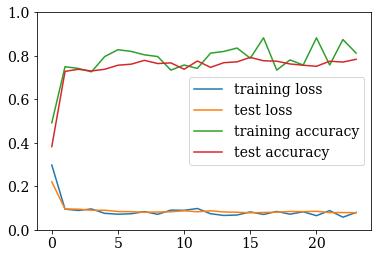

In [14]:
plt.plot(loss_list_train, label='training loss')
plt.plot(loss_list, label='test loss')
plt.plot(acc_list_train, label='training accuracy')
plt.plot(acc_list, label='test accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [15]:
jnp.save(f'./{dataset}/central_loss.npy', loss_list)
jnp.save(f'./{dataset}/central_acc.npy', acc_list)